# CNN Model 3
## Selected images with patterns and 3% None defect pattern data included. All images resized to 42x42. Accuracy of 0.32 achieved. No data augmentation done.

This code is written to ingest WM811K dataset and get trained on defect patterns and be able to distinguish and group wafers into two groups - defect pattern vs no pattern. Data was resized to 60x60. Runs existing data defect patterns without any additional data added to rebalance class. 

Sources:
1. Wafer defect classification by deep learning code: Ashadullah Shawon: https://www.kaggle.com/shawon10/wafer-defect-classification-by-deep-learning
2. Defect detection in wafer maps: Paul Bassaler: https://www.kaggle.com/paulbassaler/defect-detection-in-wafer-bin-maps


In [1]:
import os
from os.path import join

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

!pip install tensorflow
import tensorflow as tf
import keras
from keras import layers, Input, models
from tensorflow.keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier 
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

# Import modeling libraries.
import sklearn as sk
#sklearn.__version__
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from skimage.transform import resize as sk_resize

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Read the full data file that is stored locally. Look at information and data details

df=pd.read_pickle("LSWMD.pkl")
df.info()
df.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   waferMap        811457 non-null  object 
 1   dieSize         811457 non-null  float64
 2   lotName         811457 non-null  object 
 3   waferIndex      811457 non-null  float64
 4   trianTestLabel  811457 non-null  object 
 5   failureType     811457 non-null  object 
dtypes: float64(2), object(4)
memory usage: 37.1+ MB


,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
151806,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",3532.0,lot9813,14.0,[],[]
529092,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1,...",515.0,lot33123,22.0,[],[]
540316,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,...",686.0,lot33738,12.0,[],[]
421881,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1,...",723.0,lot25329,4.0,[],[]
535708,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,...",710.0,lot33474,14.0,[],[]


In [3]:
# From the dataset we have wafers with different die size and count. Look at details.
print("Number of unique die size values\n", df['dieSize'].value_counts().head())
print("\nSample of unique dies dize values", pd.unique(df['dieSize']))
print("Dies size value that occurs the most", df['dieSize'].value_counts().idxmax())

Number of unique die size values
 710.0     66961
515.0     45725
712.0     42572
1513.0    39322
776.0     29513
Name: dieSize, dtype: int64

Sample of unique dies dize values [1683. 2460.  533. ...  551.  554.  550.]
Dies size value that occurs the most 710.0


In [4]:
# Measuring the wafer map dimensions and adding a column called waferMapDim
# waferMap value is a numpy array with 0, 1, 2 values. 0-no data, 1-pure pixel die, 2-defect die
# Each die is represented by a pixel value. So, size of this waferMap array is different

# This function was used to find the original wafer image dimensions and sort them
def find_dim(x):
    dim0=np.size(x,axis=0)
    dim1=np.size(x,axis=1)
    return dim0,dim1

df['waferMapDim']=df.waferMap.apply(find_dim)
print("Die size dimension in descending order\n", df['waferMapDim'].value_counts().sort_values(ascending=False))

# Build function to resize images. Resizing to 28x28
x_dim = 42
y_dim = 42

def resize_wafers(row):
    base_map = row['waferMap']
    resize_map = sk_resize(base_map*1024,[x_dim,y_dim], anti_aliasing=True)
    return resize_map

df['resize_waferMap'] = df.apply (lambda row: resize_wafers(row), axis=1)

# With resized images to 42x42, we can get all images to be same and keep sample size high
df['resize_waferMapDim']=df.resize_waferMap.apply(find_dim)
print("Die size dimension in descending order\n", df['resize_waferMapDim'].value_counts().sort_values(ascending=False))

Die size dimension in descending order
 (32, 29)    108687
(25, 27)     64083
(49, 39)     39323
(26, 26)     30078
(30, 34)     29513
             ...  
(43, 41)         1
(49, 67)         1
(26, 44)         1
(88, 62)         1
(54, 64)         1
Name: waferMapDim, Length: 632, dtype: int64
Die size dimension in descending order
 (42, 42)    811457
Name: resize_waferMapDim, dtype: int64


In [5]:
# Re-arranging the data. Creating nuerical values for failure type and train/test type

df['failureNum']=df.failureType
df['trainTestNum']=df.trianTestLabel
mapping_type={'Center':0,'Donut':1,'Edge-Loc':2,'Edge-Ring':3,'Loc':4,'Random':5,'Scratch':6,'Near-full':7,'none':8}
mapping_traintest={'Training':0,'Test':1}
df=df.replace({'failureNum':mapping_type, 'trainTestNum':mapping_traintest})

df.sample(5)

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType,waferMapDim,resize_waferMap,resize_waferMapDim,failureNum,trainTestNum
731566,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1,...",741.0,lot44298,18.0,[],[],"(33, 29)","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","(42, 42)",[],[]
145810,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,...",712.0,lot9380,7.0,[],[],"(30, 31)","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","(42, 42)",[],[]
481829,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2,...",796.0,lot29856,13.0,[],[],"(31, 33)","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","(42, 42)",[],[]
82599,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1801.0,lot5909,6.0,[],[],"(56, 41)","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","(42, 42)",[],[]
368232,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2,...",592.0,lot22003,21.0,[],[],"(29, 27)","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","(42, 42)",[],[]


In [6]:
# Split the database into three buckets: Wafers with labels, Wafers with pattern defect, Wafers without patterns

#Wafers with labels are wafers that have some defect label provided. This includes "none" category as well
df_withlabel = df[(df['failureNum']>=0) & (df['failureNum']<=8)]
df_withlabel = df_withlabel.reset_index()
#Wafers with pattern are wafers that have some pattern. None is excluded
df_withpattern = df[(df['failureNum']>=0) & (df['failureNum']<=7)]
df_withpattern = df_withpattern.reset_index()
#Wafers with label but no defect patterns. None category
df_nonpattern = df[(df['failureNum']==8)]
print("Wafers with label", df_withlabel.shape[0])
print("Wafers with defect patterns", df_withpattern.shape[0])
print("Wafers without defect patterns", df_nonpattern.shape[0])

Wafers with label 172950
Wafers with defect patterns 25519
Wafers without defect patterns 147431


We have a significant number of wafers without labels from the total 811K wafers. For wafers with labels, maority of wafers have no defect pattern. So, most of this data can be thrown out and we can go with a smaller subset of data for our analysis.

In [7]:
# If we use full dataframe df, there are too many unlabeled values
# Even if we eliminate unlabeled values, we still have lot of none defects (147431). 
# Remove 90% of "none defects" () and throw away unlabeled values 

N=143000 #97% of 147431 data points. Throw this away at random
#Select labeled data and throw away 97% of none defects at random. Create smaller dataframe
sub_df = df_withlabel.drop(df_withlabel[df_withlabel['failureNum'].eq(8)].sample(N).index)
#sub_df = df_withpattern.loc[df_withpattern['waferMapDim'] == (26, 26)]
#sub_df = df_withpattern

Imlist = np.ones((1, 42, 42))
label = []

for i in range(len(sub_df)):
    # Remove data without any labels
    if len(sub_df.iloc[i,:]['failureType']) == 0:
        continue
    Imlist = np.concatenate((Imlist, sub_df.iloc[i,:]['resize_waferMap'].reshape(1, 42, 42)))
    label.append(sub_df.iloc[i,:]['failureType'][0][0])
    
#The first elemet in Imlist is just composed with ones, so it isn't intersesting, let's remove it
Imlist=Imlist[1:]
label=np.array(label).reshape((-1,1)) #Column of labels

#We have all the values of the pixels: 0.0 is for the exterior ofthe wafer map
#2.0 is for the local impure pixel and 1.0 is for a pure pixel of the wafer map

print(np.shape(Imlist),np.shape(label))

(29950, 42, 42) (29950, 1)


In [8]:
# Imlist is a numpy array with wafermap entries. Each entry has 28 rows and 28 columns
# We now turn all this data into a single column of data
# Each pixel value of each image is now separate and we can use it separately to process deep learning
Imlist_redo=Imlist.reshape((-1,42,42,1)) 
print(np.shape(Imlist_redo), len(Imlist_redo))

# In order to process deep learning, we have to use data composed by 1 only. In other words we have to
# change the data of 0-blank, 1-clean diw, 2- defect die into a data set composed of 1 only. We have to
# transform the dataset into a sequence of 1s for deep learning.
# for 0.0 we will use [1, 0, 0]
# for 1.0 we will use [0, 1, 0]
# for 2.0 we will use [0, 0, 1]

new_Imlist = np.zeros((len(Imlist_redo), 42, 42, 3)) 

for w in range(len(Imlist_redo)):
    for i in range(42):
        for j in range(42):
            new_Imlist[w, i, j, int(Imlist_redo[w, i, j])] = 1

print("New_Imlist shape", np.shape(new_Imlist))

(29950, 42, 42, 1) 29950
New_Imlist shape (29950, 42, 42, 3)


new_Imlist is the final image list. It has 29950 images. Each image has a 28x28 pixel value. Each pixel has a x3 value. [1,0,0] representing 0, which is blank data. [0, 1, 0] represents a clean die. [0, 0, 1] represents a defective die. For this data set, we have all defects and none defect pattern wafers as well. Below we can see the distribution of data. Near-full has lowest data set followed by donut and random.

In [9]:
#Keep processed data separately to avoid repeated running
new_Imlist_original = new_Imlist
label_original = label

In [10]:
#Now we can see the shape of our lists, just to now how big is our dataset
for l in np.unique(label) :
    print('{} : {}'.format(l, len(label[label==l])))
print(np.shape(new_Imlist), np.shape(label))

Center : 4294
Donut : 555
Edge-Loc : 5189
Edge-Ring : 9680
Loc : 3593
Near-full : 149
Random : 866
Scratch : 1193
none : 4431
(29950, 42, 42, 3) (29950, 1)


In [11]:
#In order to process the test, we need a matrix of labels
for i, l in enumerate(np.unique(label)):
    label[label==l] = i
    
label = tf.keras.utils.to_categorical(label)

#Now we know this information, we can lower the heavyness of the dataset, because it is too huge
#new_IMLIST=new_Imlist[0:25000]
#new_LABEL=label[0:25000]
#test_Imlist=new_Imlist[25001:29950]
#test_label=label[25001:29950]
#print(np.shape(new_LABEL))

im_train, im_test, label_train, label_test = train_test_split(new_Imlist, label, test_size=0.33, random_state=42)
print(np.shape(im_train),np.shape(im_test),np.shape(label_train),np.shape(label_test))

(20066, 42, 42, 3) (9884, 42, 42, 3) (20066, 9) (9884, 9)


A Convolutional based Encoder-Decoder Neural Network is an encoder-decoder neural network that consists of a encoder neural network and a decoder neural network in which one or both are convolutional neural networks. 

An encoder is a network that takes the input, and output a feature map/vector/tensor. These feature vector hold the information, the features, that represents the input. The decoder is again a network (usually the same network structure as encoder but in opposite orientation) that takes the feature vector from the encoder, and gives the best closest match to the actual input or intended output.

Once trained, the encoder will gives feature vector for input that can be use by decoder to construct the input with the features that matter the most to make the reconstructed input recognizable as the actual input.

In [12]:
# Stochastic gradient descent is an iterative learning algorithm that uses a training dataset to update a model.
# The batch size is a hyperparameter of gradient descent that controls the number of training samples to work 
# through before the model’s internal parameters are updated.The number of epochs is a hyperparameter of gradient 
# descent that controls the number of complete passes through the training dataset.

# One epoch is when entire dataset is passed forward and backward through network once
# But instead we train the dataset into different batches and pass it through
# If 2000 data samples, divide into 500 batch size, it will take 4 iterations to run 1 epoch
epoch=10
batch_size=5000

input_shape = (42, 42, 3)
input_tensor = Input(input_shape)

'''
Set up the encode layer. Relu activation function, in this case, just keep the values we are convoluting, 
and it let us do the same for the output tensor created.
'''
encode = layers.Conv2D(64, (3,3), padding='same', activation='relu')(input_tensor)

'''
Now that the encoder is settled, we have to code the latent vector, which is the last part of the encoder, and 
it aims to encapsulate the information for all input elements in order to help the decoder make accurate 
predictions. It acts as the initial hidden state of the decoder part of the model.
'''

#Only the highest value of a region is kept.Max pooling is keeping the most activated pixels (ones with the highest 
#values) and discards the rest.

latent_vector = layers.MaxPool2D()(encode)
encoder = models.Model(input_tensor, latent_vector)

'''
And now the decoder, and then connecting all the layers, to finally have the predicted output tensor. A stack of 
several recurrent units where each predicts an outputEach recurrent unit accepts a hidden state from the previous 
unit and produces and output as well as its own hidden state.
'''

#It is the transposed convolution layer, so the inverse step as the encoder
decode_layer_1 = layers.Conv2DTranspose(64, (3,3), padding='same', activation='relu') 

#Repeats the rows and columns of the data by size[0] and size[1] respectively.
decode_layer_2 = layers.UpSampling2D() 
output_tensor = layers.Conv2DTranspose(3, (3,3), padding='same', activation='sigmoid')

#After having regarding the shape I needed for the start of the decoder, I have to define it.
decoder_input = Input((21, 21, 64)) #decoder input was 13, 13, 64 for 26x26
decode = decode_layer_1(decoder_input)
decode = decode_layer_2(decode)

decoder = models.Model(decoder_input, output_tensor(decode))

#Now we have all the model, let's prepare the dataset, with normal wafers, and noised wafers, so that we will have some 
#data to make the machine predict their label

encoded_Im = encoder.predict(new_Imlist)
noised_encoded_Im = encoded_Im + np.random.normal(loc=0, scale=0.1, size = (len(encoded_Im), 21, 21, 64))
# original code was 13, 13, 64 instead of 30, 30, 64 representing 26x26

We can see that this classification is not uniform and it creates a biased distribution of defect types in the dataset. We also do not have sufficient data that has labels and defect patterns. Once we remove unlabeled data and the wafers without defect patterns, we have only 877 entries.

In [13]:
#Let's now create the real model we will use for the CNN test
def create_model():
    input_shape = (42, 42, 3)
    input_tensor = Input(input_shape)

    conv_1 = layers.Conv2D(16, (3,3), activation='relu', padding='same')(input_tensor)
    conv_2 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(conv_1)
    conv_3 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(conv_2)

    flat = layers.Flatten()(conv_3)

    dense_1 = layers.Dense(512, activation='relu')(flat)
    dense_2 = layers.Dense(128, activation='relu')(dense_1)
    output_tensor = layers.Dense(9, activation='softmax')(dense_2)

    model = models.Model(input_tensor, output_tensor)
    model.compile(optimizer='Adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

    return model

In [14]:
model = KerasClassifier(build_fn=create_model, epochs=epoch, batch_size=batch_size, verbose=2) 
# 3-Fold Crossvalidation
kfold = KFold(n_splits=3, shuffle=True, random_state=42) 
results = cross_val_score(model, im_train, label_train, cv=kfold)
print(results)
print("training accuracy = ", np.mean(results))

Epoch 1/10
3/3 - 75s - loss: 4.1343 - accuracy: 0.1444 - 75s/epoch - 25s/step
Epoch 2/10
3/3 - 65s - loss: 3.3715 - accuracy: 0.1653 - 65s/epoch - 22s/step
Epoch 3/10
3/3 - 62s - loss: 2.0953 - accuracy: 0.2575 - 62s/epoch - 21s/step
Epoch 4/10
3/3 - 61s - loss: 2.0671 - accuracy: 0.3254 - 61s/epoch - 20s/step
Epoch 5/10
3/3 - 62s - loss: 1.8582 - accuracy: 0.3254 - 62s/epoch - 21s/step
Epoch 6/10
3/3 - 61s - loss: 1.8886 - accuracy: 0.2694 - 61s/epoch - 20s/step
Epoch 7/10
3/3 - 61s - loss: 1.8286 - accuracy: 0.3254 - 61s/epoch - 20s/step
Epoch 8/10
3/3 - 1466s - loss: 1.8311 - accuracy: 0.3254 - 1466s/epoch - 489s/step
Epoch 9/10
3/3 - 63s - loss: 1.8255 - accuracy: 0.3254 - 63s/epoch - 21s/step
Epoch 10/10
3/3 - 64s - loss: 1.8224 - accuracy: 0.3254 - 64s/epoch - 21s/step
2/2 - 8s - loss: 1.8177 - accuracy: 0.3177 - 8s/epoch - 4s/step
Epoch 1/10
3/3 - 59s - loss: 6.0322 - accuracy: 0.1725 - 59s/epoch - 20s/step
Epoch 2/10
3/3 - 58s - loss: 3.1062 - accuracy: 0.1503 - 58s/epoch - 19s

In [15]:
#Now we have done the training is done, let's validate the learning with the test dataset
history = model.fit(im_train, label_train, epochs=epoch, batch_size=batch_size, validation_data=(im_test, label_test))

Epoch 1/10
5/5 - 103s - loss: 9.8158 - accuracy: 0.2370 - val_loss: 1.9053 - val_accuracy: 0.3240 - 103s/epoch - 21s/step
Epoch 2/10
5/5 - 100s - loss: 1.9536 - accuracy: 0.3228 - val_loss: 2.0347 - val_accuracy: 0.3240 - 100s/epoch - 20s/step
Epoch 3/10
5/5 - 99s - loss: 1.9555 - accuracy: 0.3228 - val_loss: 1.8364 - val_accuracy: 0.3240 - 99s/epoch - 20s/step
Epoch 4/10
5/5 - 99s - loss: 1.8531 - accuracy: 0.3228 - val_loss: 1.8230 - val_accuracy: 0.3240 - 99s/epoch - 20s/step
Epoch 5/10
5/5 - 99s - loss: 1.8311 - accuracy: 0.3228 - val_loss: 1.8284 - val_accuracy: 0.3240 - 99s/epoch - 20s/step
Epoch 6/10
5/5 - 99s - loss: 1.8286 - accuracy: 0.3228 - val_loss: 1.8212 - val_accuracy: 0.3240 - 99s/epoch - 20s/step
Epoch 7/10
5/5 - 98s - loss: 1.8232 - accuracy: 0.3228 - val_loss: 1.8185 - val_accuracy: 0.3240 - 98s/epoch - 20s/step
Epoch 8/10
5/5 - 101s - loss: 1.8230 - accuracy: 0.3228 - val_loss: 1.8197 - val_accuracy: 0.3240 - 101s/epoch - 20s/step
Epoch 9/10
5/5 - 99s - loss: 1.822

In [16]:
#And finally let's see what is the testing accuracy

score = model.score(im_test, label_test)
print('Testing Accuracy:',score)

2/2 - 12s - loss: 1.8188 - accuracy: 0.3240 - 12s/epoch - 6s/step
Testing Accuracy: 0.3239579200744629


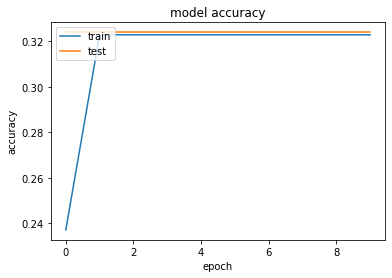

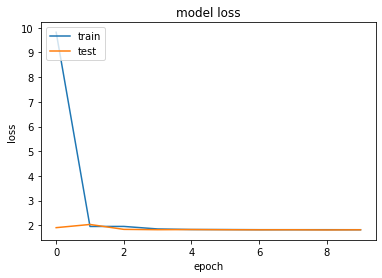

In [17]:
#Let's now plot the differnces in the losses and the accuracies between the training and the test
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()